# Intrusion Detection System

* Objective: Create a random forest model to detect if there has been an intrusion in the system.
* Intrusion Detection Evaluation dataset: https://www.kaggle.com/cicdataset/cicids2017

# Imports

In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import joblib


from sklearn.metrics import classification_report

from sklearn import metrics as metrics


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:20,.4f}'.format
pd.options.display.max_colwidth=500
np.set_printoptions(threshold=sys.maxsize)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9a1ea10k because the default path (/home/qs/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Data Preparation

In [2]:
data = pd.read_csv('CICIDS2017.csv')
data.shape

(2830743, 80)

In [3]:
## Remove rows with null values
data_cleaned=data.dropna().copy()
# Remove fields with infinity type to work in model 
data_cleaned=data_cleaned.loc[data_cleaned['FlowBytes/s']!=float('inf')]
data_cleaned.shape

(2827876, 80)

In [4]:
data_cleaned.head(10)

,Unnamed: 0,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,0,49188,4,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,"3,000,000.0000","500,000.0000",4.0000,0.0000,4,4,4,4.0000,0.0000,4,4,0,0.0000,0.0000,0,0,0,0,0,0,40,0,"500,000.0000",0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
1,1,49188,1,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,"12,000,000.0000","2,000,000.0000",1.0000,0.0000,1,1,1,1.0000,0.0000,1,1,0,0.0000,0.0000,0,0,0,0,0,0,40,0,"2,000,000.0000",0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
2,2,49188,1,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,"12,000,000.0000","2,000,000.0000",1.0000,0.0000,1,1,1,1.0000,0.0000,1,1,0,0.0000,0.0000,0,0,0,0,0,0,40,0,"2,000,000.0000",0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
3,3,49188,1,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,"12,000,000.0000","2,000,000.0000",1.0000,0.0000,1,1,1,1.0000,0.0000,1,1,0,0.0000,0.0000,0,0,0,0,0,0,40,0,"2,000,000.0000",0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
4,4,49486,3,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,"4,000,000.0000","666,666.6667",3.0000,0.0000,3,3,3,3.0000,0.0000,3,3,0,0.0000,0.0000,0,0,0,0,0,0,40,0,"666,666.6667",0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,245,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
5,5,49486,1,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,"12,000,000.0000","2,000,000.0000",1.0000,0.0000,1,1,1,1.0000,0.0000,1,1,0,0.0000,0.0000,0,0,0,0,0,0,40,0,"2,000,000.0000",0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,245,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
6,6,49486,1,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,"12,000,000.0000","2,000,000.0000",1.0000,0.0000,1,1,1,1.0000,0.0000,1,1,0,0.0000,0.0000,0,0,0,0,0,0,40,0,"2,000,000.0000",0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,245,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
7,7,49486,1,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,"12,000,000.0000","2,000,000.0000",1.0000,0.0000,1,1,1,1.0000,0.0000,1,1,0,0.0000,0.0000,0,0,0,0,0,0,40,0,"2,000,000.0000",0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,245,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
8,8,88,609,7,4,484,414,233,0,69.1429,111.9679,207,0,103.5000,119.5115,"1,474,548.4401","18,062.3974",60.9000,115.1950,381,2,609,101.5000,177.0895,460,2,467,155.6667,263.5609,460,3,0,0,0,0,164,104,"

In [5]:
data_cleaned.Label.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'Bot', 'DDoS',
       'PortScan'], dtype=object)

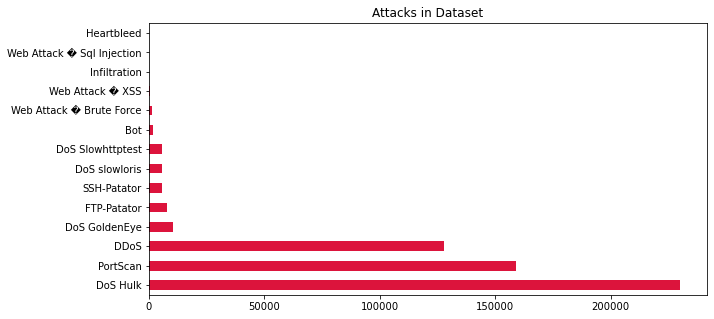

In [6]:
## Types of attacks featured in dataset
data_cleaned.loc[data_cleaned.Label!='BENIGN'].Label.value_counts().plot.barh(figsize=(10,5), color='crimson')
plt.title('Attacks in Dataset')
plt.show()

In [7]:
data_cleaned.Label.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'Bot', 'DDoS',
       'PortScan'], dtype=object)

In [8]:
## Create target field (intrusion or no intrusion) for Not Attack Specific Models
data_cleaned['Intrusion']=np.nan
data_cleaned.loc[data_cleaned['Label'] == 'BENIGN', 'Intrusion'] = 0
data_cleaned.loc[data_cleaned['Label'] != 'BENIGN', 'Intrusion'] = 1

In [9]:
data_cleaned.Intrusion.value_counts()

0.0000    2271320
1.0000     556556
Name: Intrusion, dtype: int64

In [11]:
print('Initial Intrusion ratio:',data_cleaned.Intrusion.sum()/len(data_cleaned.Intrusion))

Initial Intrusion ratio: 0.19681060980042972


In [12]:
data_cleaned['Intrusion']=data_cleaned.Intrusion.astype('int')

In [13]:
## Feature list
feature_list=list(data_cleaned.iloc[:,1:79].columns)

In [18]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(data_cleaned[['FlowBytes/s',
                                        'BwdPacketLengthStd',
                                        'DestinationPort',
                                        'SubflowFwdBytes',
                                        'TotalLengthofFwdPackets',
                                        'Init_Win_bytes_forward',
                                        'act_data_pkt_fwd',
                                        'FwdIATMin',
                                        'BwdPackets/s',
                                        'AveragePacketSize'    
                                    ]], data_cleaned.Intrusion)

print('New Intrustion ratio:',y.sum()/len(y))

New Intrustion ratio: 0.5


In [21]:
print(y.sum())
print(y.count()-y.sum())

556556
556556


# Random Forest Model

In [163]:
# Features
#X=np.array(data_cleaned.iloc[:,1:79])
# Target
#y=np.array(data_cleaned.Intrusion)

# Split into training and testing data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 42)

scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)



print('Training Features Shape:', train_X.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_X.shape)
print('Testing Labels Shape:', test_y.shape)

Training Features Shape: (834834, 10)
Training Labels Shape: (834834,)
Testing Features Shape: (278278, 10)
Testing Labels Shape: (278278,)


In [164]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [165]:
# Instantiate model with 10 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)

# Train the model on training data
rf.fit(train_X, train_y)

RandomForestRegressor(n_estimators=10, random_state=42)

In [166]:
# Predict and Test
rf_predictions = rf.predict(test_X)
rf.score(test_X,test_y)

0.9956896815110071

In [167]:
# round using a threshold of 0.5
rf_predictions=np.round(rf_predictions,0)

In [168]:
print("Accuracy:",metrics.accuracy_score(test_y, rf_predictions))

Accuracy: 0.9987314843429951


<AxesSubplot:>

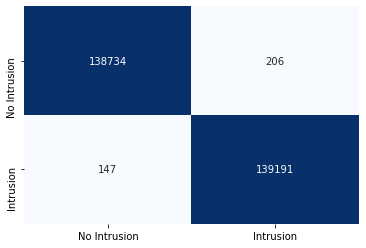

In [169]:
sns.heatmap(confusion_matrix(test_y, rf_predictions),xticklabels=['No Intrusion','Intrusion'],yticklabels=['No Intrusion','Intrusion'], annot=True, cmap='Blues', cbar=False, fmt='g')

In [170]:
# Save model 
joblib.dump(rf, 'RF_intrusiondetection.pkl')

['RF_intrusiondetection.pkl']

### Feature Importance

Text(0.5, 1.0, 'Feature Performance')

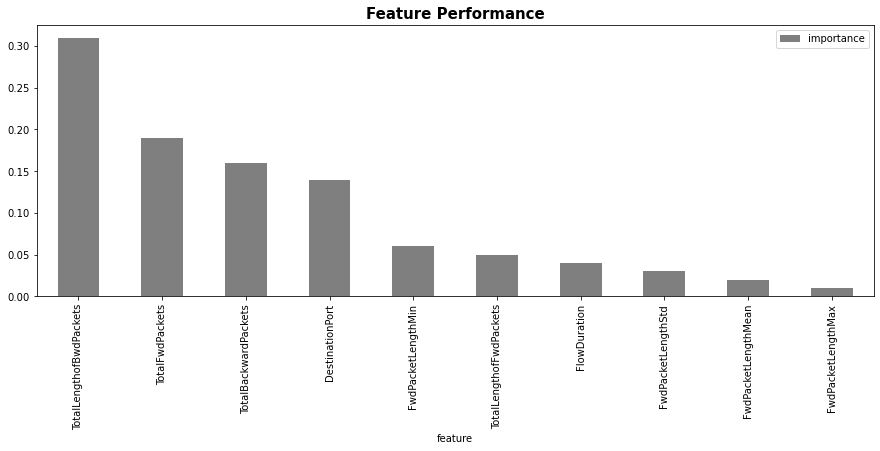

In [172]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Plot feature importance
feat_impDF=pd.DataFrame()
for feat,imp in feature_importances:
    feat_impDF=feat_impDF.append({'feature':feat,'importance':imp},ignore_index=True)

feat_impDF.plot.bar(x='feature',y='importance',figsize=(15,5), color='black', alpha=0.5)
plt.title('Feature Performance', size=15, weight='bold')

# Decision Tree Classifier

In [173]:

print('Training Features Shape:', train_X.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_X.shape)
print('Testing Labels Shape:', test_y.shape)

Training Features Shape: (834834, 10)
Training Labels Shape: (834834,)
Testing Features Shape: (278278, 10)
Testing Labels Shape: (278278,)


In [174]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train_X,train_y)

#Predict the response for test dataset
clf_predictions = clf.predict(test_X)

In [175]:
print("Accuracy:",metrics.accuracy_score(test_y, clf_predictions))

Accuracy: 0.9985302467316856


<AxesSubplot:>

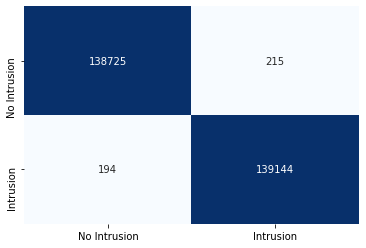

In [176]:
sns.heatmap(confusion_matrix(test_y, clf_predictions),xticklabels=['No Intrusion','Intrusion'],yticklabels=['No Intrusion','Intrusion'], annot=True, cmap='Blues', cbar=False, fmt='g')

In [177]:
# Save model 
joblib.dump(clf, 'clf_DecisionTree.pkl')

['clf_DecisionTree.pkl']

Text(0.5, 1.0, 'Feature Performance')

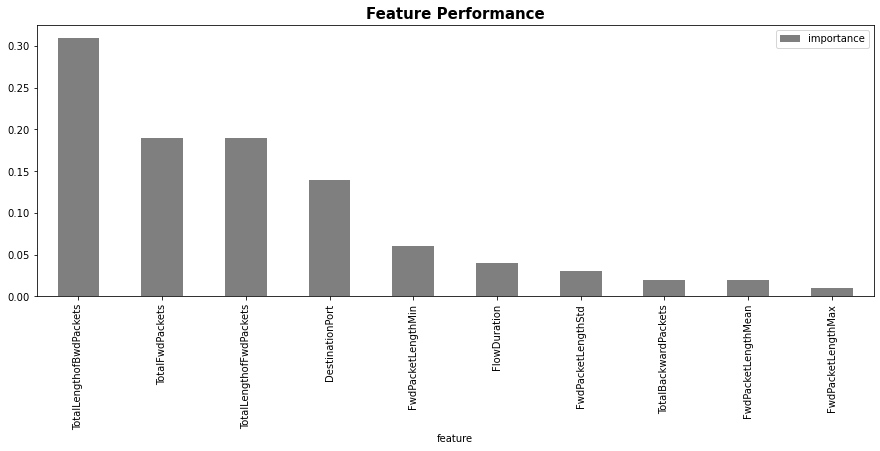

In [178]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Plot feature importance
feat_impDF=pd.DataFrame()
for feat,imp in feature_importances:
    feat_impDF=feat_impDF.append({'feature':feat,'importance':imp},ignore_index=True)

feat_impDF.plot.bar(x='feature',y='importance',figsize=(15,5), color='black', alpha=0.5)
plt.title('Feature Performance', size=15, weight='bold')